# Exploration of the dataset that represents L1 trigger data
The details about the dataset generation can be found here:
https://www.nature.com/articles/s41597-022-01187-8

## Access to the data
Follow the link to download [background data](https://cernbox.cern.ch/s/0YwwR5LoRoerYT1), [background IDs](https://cernbox.cern.ch/s/f5iRguLcgFUdrku), [signal datasets](https://cernbox.cern.ch/s/NGMnr4EHaH26AtL) and [pre-trained scaler](https://cernbox.cern.ch/s/ONixr850ZVwzmem). Then load the files to this notebook. Alternatively, you could place the files on your google drive and connect it as shown in the cell below.

In [2]:
import numpy as np
#import pickle
import matplotlib.pyplot as plt
import os
#from scripts.forest import Forest
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
#import scripts.timeseries as ts
import pandas as pd
import time
import scipy.io as sio
from sklearn import metrics
import rrcf
import h5py
import math
import copy
from typing import List
import numpy as np
from numpy.core import ndarray
#from scripts.hg import Histogram
import matplotlib.pyplot as plt
from math import log

In [3]:
# Load background data
datasets = np.load('datasets_-1.npz')
#x_train = datasets['x_train']
#y_train = datasets['y_train']
#x_test = datasets['x_test']
#y_test = datasets['y_test']
#x_val = datasets['x_val']
#y_val = datasets['y_val']


x_train = np.delete(datasets['x_train'].reshape(len(datasets['x_train']), 57), 1, axis=1)
x_test = np.delete(datasets['x_test'].reshape(len(datasets['x_test']), 57), 1, axis=1)

In [4]:
# Load signals
bsm_datasets = np.load('bsm_datasets_-1.npz')

ltq = np.delete(bsm_datasets['leptoquark'].reshape(len(bsm_datasets['leptoquark']), 57), 1, axis=1)
ato4l = np.delete(bsm_datasets['ato4l'].reshape(len(bsm_datasets['ato4l']), 57), 1, axis=1)
hChToTauNu = np.delete(bsm_datasets['hChToTauNu'].reshape(len(bsm_datasets['hChToTauNu']), 57), 1, axis=1)
hToTauTau = np.delete(bsm_datasets['hToTauTau'].reshape(len(bsm_datasets['hToTauTau']), 57), 1, axis=1)




In [5]:
n_samples = 100
kwargs = {'max_depth': 10, 'n_trees': 10,  'max_samples': n_samples, 'max_buckets': 3, 'epsilon': 0.1, 'sample_axis': 1, 
  'threshold': 0}

In [6]:
def compress(arr, eps):
    min_val = np.min(arr[np.nonzero(arr)])
    max_val = np.max(arr[np.nonzero(arr)])
    k = int(math.log(max_val / min_val) / math.log(1 + eps))
    sp_vals = sorted({min_val * ((1 + eps) ** i) for i in range(k + 1)})
    sp_indices = sorted(set(np.searchsorted(arr, sp_vals)))
    compress_arr = {index: arr[index] for index in sp_indices}
    return compress_arr

class Histogram:

    def __init__(self, val, count, max_buckets, eps):
        self.num = len(val)
        self.max_buckets = max_buckets
        self.val = val
        self.count = count
        self.eps = eps
        self.err, self.b_values = approx_buckets(val, count, max_buckets, eps)

    def __str__(self):
        str_val = ""
        for i in range(self.max_buckets):
            str_val += "Level " + str(i) + ":"
            for b_val in self.b_values[i]:
                a_val, err_a, _, _, _ = self.b_values[i][b_val]
                str_val += " (" + str(a_val) + ", " + str(b_val) + "): " + str(err_a) + ", "
            str_val += "\n"
        return str_val

    def test(self):
        print(str(self))
        for i in range(1, self.max_buckets):
            print(self.compute_buckets(i))
        print("Best Buckets: ")
        print(self.best_split())

    def best_split(self):
        if self.err[0] == 0:
            return 0, 0, []
        err_red = [(self.err[0] - self.err[i]) for i in range(1, self.max_buckets)]
        var_red = np.max(err_red) / self.err[0]
        if var_red < 0:
            print("error: var_red is", var_red)
            var_red = 0
        opt = np.argmax(err_red) + 2  # why +2 and not +1 ???????
        buckets = self.compute_buckets(opt)
        return opt, var_red, buckets[1:]

    def compute_buckets(self, num_buckets):
        buckets = []
        end = self.num - 1
        k = num_buckets - 1
        while end >= 0:
            start = int(self.b_values[k][end][0])
            if start <= end:
                buckets.append(start)
            end = start - 1
            k -= 1
        return np.flip(buckets, axis=0)


def two_split(val, count):
    p_count = np.cumsum(count)
    s_count = p_count[-1] - p_count
    p_sum = np.cumsum(val*count)
    s_sum = p_sum[-1] - p_sum
    scores = (p_sum**2)[:-1]/p_count[:-1] + (s_sum**2)[:-1]/s_count[:-1]
    return scores


def approx_buckets(arr, count, max_buckets, eps):
    """params:
    vals: the array of values
    counts: the array of counts
    max_buckets: the number of buckets
    eps: an approximation parameter
    returns:
     1) an array cur_err[k], which gives the error of the best histogram with k buckets.
     2) a dictionary b_values.
    b_values stores a collection of intervals for each level k where 0 <= k < B. It is indexed by
    the level k and the endpoint b of an interval (a,b) at level k.
    The value is a 4 tuple:
    1) a: start point of the interval
    2) ApxError(b,k) for that point.
    3) sum until b
    4) sum of squares until b
    5) total count until b"""
    err_a = np.zeros(max_buckets) - 1
    cur_err = np.zeros(max_buckets)
    b_values = [{} for _ in range(max_buckets)]
    cur_sum = 0
    cur_sq = 0
    cur_pts = 0
    for j in range(len(arr)):
        cur_sum += arr[j] * count[j]
        cur_sq += (arr[j] ** 2) * count[j]
        cur_pts += count[j]
        cur_err[0] = cur_sq - cur_sum**2/cur_pts
        if cur_err[0] > (1 + eps) * err_a[0]:
            err_a[0] = cur_err[0]
        else:
            del b_values[0][j - 1]
        b_values[0][j] = (0, cur_err[0], cur_sum, cur_sq, cur_pts)
        for k in range(1, max_buckets):
            cur_err[k] = cur_err[k - 1]
            a_val = j + 1
            for b_val in b_values[k - 1].keys():
                if b_val < j:
                    _, b_err, b_sum, b_sq, b_pts = b_values[k - 1][b_val]
                    tmp_error = b_err + cur_sq - b_sq - (cur_sum - b_sum) ** 2 / (cur_pts - b_pts)
                    if tmp_error < cur_err[k]:
                        cur_err[k] = tmp_error
                        a_val = b_val + 1
            b_values[k][j] = (a_val, cur_err[k], cur_sum, cur_sq, cur_pts)
            if cur_err[k] > (1 + eps) * err_a[k]:
                err_a[k] = cur_err[k]
            else:
                del b_values[k][j - 1]
   # print(type(b_values))

    return cur_err, b_values

In [7]:
to_print = False

class Forest:
    """This creates a forest of trees, given the following list of parameters:
    1) n_trees: the number of trees
    2) max_depth: the depth of the trees
    3) max_samples: number of samples per tree
    4) max_buckets: maximum number of buckets used by the histogram
    5) epsilon: accuracy of the histogram"""
    dim = ...  # type: int
    size = ...  # type: int
    points = ...  # type: ndarray
    start = ...  # type: ndarray
    end = ...  # type: ndarray

    def __init__(self, **kwargs):
        self.n_trees = kwargs['n_trees']
        self.max_depth = kwargs['max_depth']
        self.max_samples = kwargs['max_samples']
        self.max_buckets = kwargs['max_buckets']
        self.epsilon = kwargs['epsilon']
        self.sample_axis = kwargs['sample_axis']
        self.threshold = kwargs['threshold']
        self.tree = []
        self.dimensionchosen = []   ## this is new
        self.split_dict = {}  ## new 
        self.counter_split = 0  ## new
        np.random.seed(seed = 17)
        self.n_leaves = np.zeros(self.n_trees)


        self.dim_print = []

    def fit(self, pts):
        self.points = pts
        self.dim, self.size = np.shape(self.points)
        if int(self.sample_axis*self.dim) == 0:
            print("sample_axis is too low")
            return
        self.start = np.zeros(self.dim)
        self.end = np.zeros(self.dim)
        for axis in range(self.dim):
            val = np.unique(np.array(self.points[axis]))
            if len(val) <= 1:
                print("No entropy in dimension :", axis)
                return
            self.start[axis] = (3 * val[0] - val[1]) / 2
            self.end[axis] = (3 * val[-1] - val[-2]) / 2
        k_args = {'depth': 0, 'forest': self}
        max_sample_size = np.min((self.size, self.max_depth*200))
        sample = np.random.choice(self.size, max_sample_size, replace=False)


        for i in range(self.n_trees):
            
            ###new
            self.counter_split = i
            self.split_dict[self.counter_split] = {}
            for j in range(self.dim):
                self.split_dict[self.counter_split][j] = []
            ### ok
            
            k_args['indices'] = np.random.choice(self.size, self.max_samples, replace=False)
            root_node = Node(**k_args)
            root_node.compute_density(sample)
            self.tree.append(root_node)
            self.n_leaves[i] = root_node.compute_leaf_num()

           
    def plt_scores(self, pts):
        _, n_pts = np.shape(pts)
        n_show = int(2 * self.n_trees / 3)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        #for i in range(n_pts):
        
        for i in range(0,5):
            plt.plot(np.sort(scores[:, i])[:n_show])
            plt.show()

    def predict(self, pts, err, pct=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        # the score become the self.density
        n_err = int(err * n_pts)
        min_score = np.percentile(scores, pct, axis=0)
        #print(f"min_score {min_score}")
        top_indices = np.argsort(min_score)[:n_err]
        #print(f"top_indices {top_indices}")
        anom_pts = {}
        anom_scores = {}
        anom_pct = {}
        for i in range(n_err):
            #print(f"pts[:, top_indices[i]] {pts[:, top_indices[i]]}")
            anom_pts[top_indices[i]] = pts[:, top_indices[i]]
            anom_scores[top_indices[i]] = scores[:, top_indices[i]]
            anom_pct[top_indices[i]] = min_score[top_indices[i]]
        return top_indices, anom_pts, anom_scores, anom_pct, min_score
        
##########################
### insert here a function that takes as an argument the min indices. 
    ## as a next step it then takes the min indices and constructs the trees as histos :)) 
       ## to see which variables were mostly chosen hihi    

####################################################

    def predict_print(self, pts, trees, err=1, pct=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        self.dim_print = []
        for i in trees:#range(self.n_trees):
            print("\n")
            print(f"tree nr. {i}")
            self.tree[i].compute_split_print(pts, indices, scores[i])

        #plt.hist(self.dim_print, bins = 6, range=(0,6))
 
  ########  
    def predict_depth(self, pts, err=0.1, pct=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_depth(pts, indices, scores[i])
        n_err = int(err * n_pts)
        min_score = np.percentile(scores, pct, axis=0)
        top_indices = np.argsort(min_score)[:n_err]
        anom_pts = {}
        anom_scores = {}
        anom_pct = {}
        for i in range(n_err):
            anom_pts[top_indices[i]] = pts[:, top_indices[i]]
            anom_scores[top_indices[i]] = scores[:, top_indices[i]]
            anom_pct[top_indices[i]] = min_score[top_indices[i]]
        return top_indices, anom_pts, anom_scores, anom_pct, min_score
    
    def find_min_cube(self, pts, n_err=1, pct1=50, pct2=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        min_score = np.percentile(scores, pct1, axis=0)
        top_indices = np.argsort(min_score)[:n_err]
        sort_trees = np.argsort(scores, axis=0)
        min_tree = sort_trees[int(self.n_trees*pct2/100.0)]
        boxes = []
        for i in range(0,n_err):
            print('----')
            best_tree = min_tree[top_indices[i]]
            boxes.append( self.tree[best_tree].compute_box(pts[:,top_indices[i]]) )
            # boxes = self.tree[best_tree].compute_box(pts[:,top_indices[i]])
        return top_indices, boxes


class PointSet:
    def __init__(self, node, indices):
        self.node = node
        self.indices = indices
        self.val = []
        self.count = []
        self.gap = []
        for axis in range(self.node.forest.dim):
            val, count = np.unique(np.array(self.node.forest.points[axis, self.indices]), return_counts=True)
            self.val.append(val)
            self.count.append(count)
            if len(val) <= 1:
                gap = [0]
            else:
                gap = np.zeros(len(val))
                gap[0] = (val[0] + val[1]) / 2 - self.node.cube.start[axis]
                gap[-1] = self.node.cube.end[axis] - (val[-1] + val[-2]) / 2
                for i in range(1, len(val) - 1):
                    gap[i] = (val[i + 1] - val[i - 1]) / 2
            self.gap.append(gap)


class Cube:
    def __init__(self, node, start, end):
        assert isinstance(node, Node)   # this just checks if there is a node, right??
        self.node = node
        self.child = []
        self.start = start
        self.end = end
        self.dim = len(start)
        self.split_axis = -1
        self.split_vals = []
        self.vol = 0
        for i in range(self.dim): # in the case of the thyroid, this dimension is 6
            #print(self.end[i] - self.start[i])
            self.vol += log(self.end[i] - self.start[i])  # here, why are we adding to the volume and not mupltiplying ? bc of the log ?
        #print('testing')

    def filter_indices(self, indices):
        in_lb = self.node.forest.points[:, indices] >= self.start.reshape(self.dim, 1)
        in_ub = self.node.forest.points[:, indices] < self.end.reshape(self.dim, 1)
        return [indices[i] for i in range(len(indices)) if in_lb[:, i].all() and in_ub[:, i].all()]

    def split_indices(self, pts, indices):
        n_child = len(self.child)
        #print(f"n_child {n_child}")
        if n_child == 0:
            return indices
        n_arr = len(indices)
        if n_arr == 0:
            return [[] for _ in range(n_child)]
        s_arr = pts[self.split_axis]
        #print(f"self.split_axis {self.split_axis}")
        #print(f"s_arr {s_arr}")
        s_start = self.start[self.split_axis]
        s_end = self.end[self.split_axis]
        index_split = [[] for _ in range(n_child)]
        index_split[0] = [ind for ind in indices if ((s_arr[ind] >= s_start) and (s_arr[ind] < self.split_vals[0]))]
        index_split[-1] = [ind for ind in indices if ((s_arr[ind] >= self.split_vals[-1]) and (s_arr[ind] < s_end))]
        for k in range(1, n_child - 1):
            index_split[k] = [ind for ind in indices if (s_arr[ind] >= self.split_vals[k - 1]) and
                              (s_arr[ind] < self.split_vals[k])]
        #print(f"self.split_vals : {self.split_vals}")
        #print(f"index_split :  {index_split}")
        return index_split
###################################

    def split_indices_print(self, pts, indices):
        n_child = len(self.child)
        print(f"n_child {n_child}")
        if n_child == 0:
            return indices
        n_arr = len(indices)
        if n_arr == 0:
            return [[] for _ in range(n_child)]
        s_arr = pts[self.split_axis]
        print(f"self.split_axis {self.split_axis}")
        forest.dim_print.append(self.split_axis)
        #print(f"s_arr {s_arr}")
        s_start = self.start[self.split_axis]
        s_end = self.end[self.split_axis]
        index_split = [[] for _ in range(n_child)]
        index_split[0] = [ind for ind in indices if ((s_arr[ind] >= s_start) and (s_arr[ind] < self.split_vals[0]))]
        index_split[-1] = [ind for ind in indices if ((s_arr[ind] >= self.split_vals[-1]) and (s_arr[ind] < s_end))]
        for k in range(1, n_child - 1):
            index_split[k] = [ind for ind in indices if (s_arr[ind] >= self.split_vals[k - 1]) and
                              (s_arr[ind] < self.split_vals[k])]
        print(f"self.split_vals : {self.split_vals}")
        print(f"index_split :  {index_split}")
        
        return index_split
###################################
class Node:

    def __init__(self, depth, forest, **kwargs):
        self.depth = depth
        self.forest = forest

        if self.depth == 0:
            self.id_string = [0]
            self.cube = Cube(self, self.forest.start, self.forest.end)
            self.point_set = PointSet(self, kwargs['indices'])
        else:
            self.id_string = kwargs['id']
            self.cube = Cube(self, kwargs['start'], kwargs['end'])
            self.point_set = PointSet(self, self.cube.filter_indices(kwargs['indices']))
        self.density = -1
        self.child = []
        if (self.depth < self.forest.max_depth) and (len(self.point_set.indices) > 1):
            self.find_split()

    def find_split(self): # here we find out which axis gives us what variance reduction ..
        imp_axis = [axis for axis in range(self.cube.dim) if len(self.point_set.val[axis]) > 1]
        #print(f"important axis length {len(imp_axis)}")
        if not imp_axis:
            return
        max_axes = min(len(imp_axis), int(self.forest.sample_axis * self.cube.dim))
        s_axes = np.random.choice(imp_axis, max_axes, replace=False)
        buckets = {}
        var_red = {}
        for axis in s_axes:
            hist = Histogram(self.point_set.gap[axis] / self.point_set.count[axis], self.point_set.count[axis], self.forest.max_buckets, self.forest.epsilon)
            _, var_red[axis], buckets[axis] = hist.best_split()
        #print(f"var_red{var_red[0]}, buckets {buckets[0]}")
        if np.max(list(var_red.values())) <= self.forest.threshold:
            return
        split_axis = np.random.choice(s_axes, p=list(var_red.values()) / np.sum(list(var_red.values())))
        #print(f"s_axes {s_axes}, p {list(var_red.values()) / np.sum(list(var_red.values()))} ")
        #print(f"split_axis {split_axis}")
        # here the choice is based on probability?
        self.cube.split_axis = split_axis
        self.cube.split_vals = [(self.point_set.val[split_axis][i - 1] + self.point_set.val[split_axis][i]) / 2 for i in
                                buckets[split_axis]]  
        # okay but i think truly THIS is where the actual splitting is happening.... right ???????????????
        # split_axis a good variable to keep track of bc.. thats where it's starting to split :) 
        # but the choice seems to be based on probability rather than a set criteria.. am i wrong?
        # so the p input tells the probability distribution of it :)) so the random choice is based on a pdf instead of assuming its uniform
        self.forest.dimensionchosen.append(split_axis)  ## new
        #print(f"split_axis {split_axis}, split_vals {self.cube.split_vals}")
        ## here to store it in the dictionary
        self.forest.split_dict[self.forest.counter_split][split_axis].append(self.cube.split_vals)  ## new
        ##
        for i in range(len(self.cube.split_vals) + 1):
            new_start = np.array(self.cube.start)
            new_end = np.array(self.cube.end)
            if 0 < i < len(self.cube.split_vals):
                new_start[split_axis] = self.cube.split_vals[i - 1]
                new_end[split_axis] = self.cube.split_vals[i]
            elif i == 0:
                new_end[split_axis] = self.cube.split_vals[0]
            else:  # i == len(self.cube.split_vals)
                new_start[split_axis] = self.cube.split_vals[-1]
            new_id = copy.deepcopy(self.id_string)
            new_id.append(i)
            kwargs = {'start': new_start, 'end': new_end}
            kwargs.update({'indices': self.point_set.indices, 'id': new_id})
            child_node = Node(self.depth + 1, self.forest, **kwargs) # recursive Node
            self.child.append(child_node)
            self.cube.child.append(child_node.cube)

    def compute_density(self, indices):
        num = len(indices)
        if num == 0:
            self.density = 0
            self.child = []
            self.cube.child = []
            self.cube.split_axis = -1
            return
        self.density = log(num) - self.cube.vol # why this equation
        #print(f"density {self.density}, num {num}, cube.vol {self.cube.vol}")
        if self.child:
            index_split = self.cube.split_indices(self.forest.points, indices)
            for i in range(len(self.child)):
                self.child[i].compute_density(index_split[i])

    def compute_leaf_num(self):
        if self.child:
            leaves = 0
            for i in range(len(self.child)):
                leaves += self.child[i].compute_leaf_num()
            return leaves
        else:
            return 1

    # here we get the density // score !
    
    def compute_split(self, pts, indices, scores):
        if self.child:
            index_split = self.cube.split_indices(pts, indices)
            for i in range(len(self.child)):
                if len(index_split[i]) > 0:
                    self.child[i].compute_split(pts, index_split[i], scores)
        else:
            scores[indices] = self.density


    #############################################

    def compute_split_print(self, pts, indices, scores):
        if self.child:
            index_split = self.cube.split_indices_print(pts, indices)
            for i in range(len(self.child)):
                if len(index_split[i]) > 0:
                    self.child[i].compute_split_print(pts, index_split[i], scores)
        else:
            print(f"no more child and the score given is {self.density}")
            scores[indices] = self.density
    ###############################################
            
    def compute_box(self, pts):
        if self.child:
            n_child = len(self.child)
            s_arr = pts[self.cube.split_axis]
            print('splitting on axis '+str(self.cube.split_axis)) 
            s_start = self.cube.start[self.cube.split_axis]
            s_end = self.cube.end[self.cube.split_axis]
            if ((s_arr >= s_start) and (s_arr < self.cube.split_vals[0])):
                #print('splitting on axis '+str(self.cube.split_axis)) 
                return(self.child[0].compute_box(pts))
            elif ((s_arr >= self.cube.split_vals[-1]) and (s_arr < s_end)):
                #print('splitting on axis '+str(self.cube.split_axis)) 
                return(self.child[-1].compute_box(pts))
            else:
                for k in range(1, n_child - 1):
                    if (s_arr >= self.cube.split_vals[k - 1]) and (s_arr < self.cube.split_vals[k]):
                        #print(str(k)+'splitting on axis '+str(self.cube.split_axis)+'\n') 
                        return(self.child[k].compute_box(pts))
        else:
            return self.cube
        
    def compute_depth(self, pts, indices, scores):
        if self.child:
            index_split = self.cube.split_indices(pts, indices)
            for i in range(len(self.child)):
                if len(index_split[i]) > 0:
                    self.child[i].compute_depth(pts, index_split[i], scores)
        else:
            scores[indices] = self.depth    

    def __str__(self):
        str_val = "Id: " + str(self.id_string) + "\n"
        str_val += "Boundary: "
        for i in range(self.cube.dim):
            str_val += " [" + str(self.cube.start[i]) + ", " + str(self.cube.end[i]) + "]"
            if i < self.cube.dim - 1:
                str_val += " x"
            else:
                str_val += "\n"
        str_val += "Points:\n " + str(np.transpose(self.point_set.points)) + "\n"
        str_val += "Indices: " + str(self.point_set.indices) + "\n"
        return str_val

    def print_node(self):
        print_list = [self]
        while print_list:
            node = print_list.pop(0)
            print(str(node))
            print_list.extend(node.child)

In [8]:
forest = Forest(**kwargs)

In [9]:
output_ew = forest.fit(np.transpose(x_train))

In [21]:
top_indices, anom_data, anom_scores, pst, min_score = forest.predict(np.transpose(x_test), err=0.1)

In [22]:
top_indices_l, anom_data_ltq, anom_scores_l, pst_ltq, min_score_l = forest.predict(np.transpose(ltq), err=0.1)

In [23]:
top_indices_ato4l, anom_data_ato4l, anom_scores_ato4l, pst_ato4l, min_score_ato4l = forest.predict(np.transpose(ato4l), err=0.1)

In [24]:
top_indices_hToTauTau, anom_data_hToTauTau, anom_scores_hToTauTau, pst_hToTauTau, min_score_hToTauTau = forest.predict(np.transpose(hToTauTau), err=0.1)

In [25]:
top_indices_hChToTauNu, anom_data_hChToTauNu, anom_scores_hChToTauNu, pst_hChToTauNu, min_score_hChToTauNu = forest.predict(np.transpose(hChToTauNu), err=0.1)

In [26]:
from sklearn.metrics import roc_curve, auc

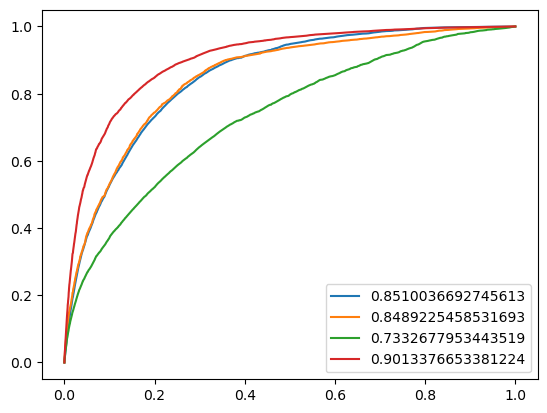

In [27]:
trueVal_lq = np.concatenate((np.ones(len(min_score_l)), np.zeros(len(min_score))))
predVal_loss_lq = np.concatenate((-min_score_l, -min_score))
fpr_loss_lq, tpr_loss_lq, threshold_loss_lq = roc_curve(trueVal_lq, predVal_loss_lq)
auc_loss_lq = auc(fpr_loss_lq, tpr_loss_lq)
plt.plot(fpr_loss_lq, tpr_loss_lq, "-", label=f"{auc_loss_lq}", linewidth=1.5)


trueVal_ato4l = np.concatenate((np.ones(len(min_score_ato4l)), np.zeros(len(min_score))))
predVal_loss_ato4l = np.concatenate((-min_score_ato4l, -min_score))
fpr_loss_ato4l, tpr_loss_ato4l, threshold_loss_ato4l = roc_curve(trueVal_ato4l, predVal_loss_ato4l)
auc_loss_ato4l = auc(fpr_loss_ato4l, tpr_loss_ato4l)
plt.plot(fpr_loss_ato4l, tpr_loss_ato4l, "-", label=f"{auc_loss_ato4l}", linewidth=1.5)

trueVal_hToTauTau = np.concatenate((np.ones(len(min_score_hToTauTau)), np.zeros(len(min_score))))
predVal_loss_hToTauTau = np.concatenate((-min_score_hToTauTau, -min_score))
fpr_loss_hToTauTau, tpr_loss_hToTauTau, threshold_loss_hToTauTau = roc_curve(trueVal_hToTauTau, predVal_loss_hToTauTau)
auc_loss_hToTauTau = auc(fpr_loss_hToTauTau, tpr_loss_hToTauTau)
plt.plot(fpr_loss_hToTauTau, tpr_loss_hToTauTau, "-", label=f"{auc_loss_hToTauTau}", linewidth=1.5)


trueVal_hChToTauNu = np.concatenate((np.ones(len(min_score_hChToTauNu)), np.zeros(len(min_score))))
predVal_loss_hChToTauNu = np.concatenate((-min_score_hChToTauNu, -min_score))
fpr_loss_hChToTauNu, tpr_loss_hChToTauNu, threshold_loss_hChToTauNu = roc_curve(trueVal_hChToTauNu, predVal_loss_hChToTauNu)
auc_loss_hChToTauNu = auc(fpr_loss_hChToTauNu, tpr_loss_hChToTauNu)
plt.plot(fpr_loss_hChToTauNu, tpr_loss_hChToTauNu, "-", label=f"{auc_loss_hChToTauNu}", linewidth=1.5)
plt.legend()

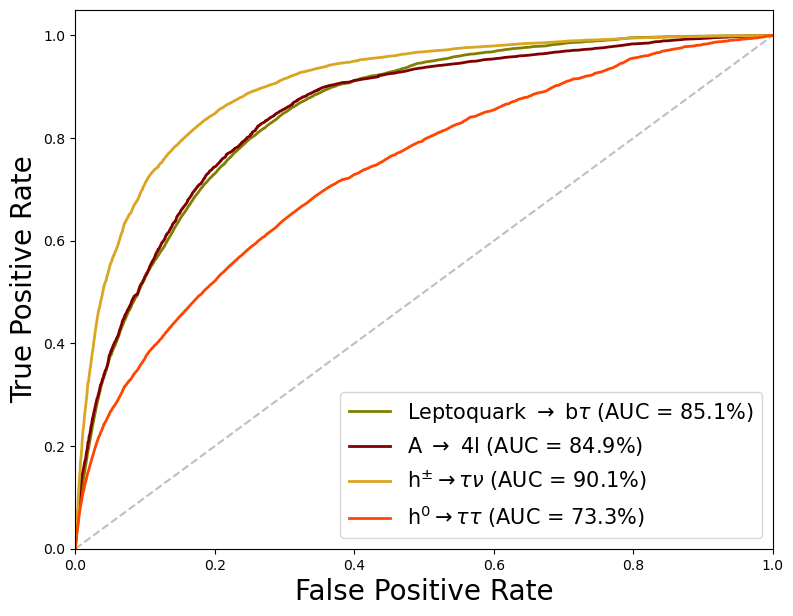

In [29]:
plt.figure(figsize=(9, 7))
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
plt.plot(fpr_loss_lq, tpr_loss_lq, lw=2, color='olive', label='Leptoquark $\\rightarrow$ b$\\tau$ (AUC = %.1f%%)' % (auc_loss_lq * 100))
plt.plot(fpr_loss_ato4l, tpr_loss_ato4l,  lw=2, color='maroon', label='A $\\rightarrow$ 4l (AUC = %.1f%%)' % (auc_loss_ato4l * 100))

plt.plot(fpr_loss_hChToTauNu, tpr_loss_hChToTauNu, color='goldenrod', lw=2, label='h$^{\\pm} \\rightarrow \\tau  \\nu $ (AUC = %.1f%%)' % (auc_loss_hChToTauNu * 100))
plt.plot(fpr_loss_hToTauTau, tpr_loss_hToTauTau,  lw=2, color='orangered',  label='h$^0 \\rightarrow \\tau \\tau$ (AUC = %.1f%%)' % (auc_loss_hToTauTau * 100))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver Operating Characteristics (ROC) Curves for different BSM signals')
plt.legend(loc='lower right',fontsize=15)
# plt.tight_layout()
plt.savefig('roc_pid_lin.png')
plt.show()

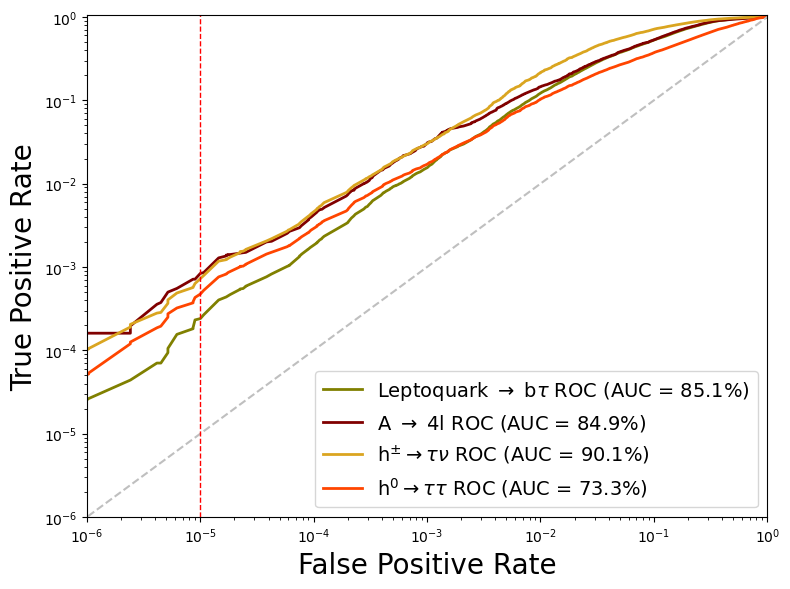

In [65]:
plt.figure(figsize=(8, 6))

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classification')
plt.plot(fpr_loss_lq, tpr_loss_lq, lw=2, color='olive', label='Leptoquark $\\rightarrow$ b$\\tau$ ROC (AUC = %.1f%%)' % (auc_loss_lq * 100))
plt.plot(fpr_loss_ato4l, tpr_loss_ato4l,  lw=2, color='maroon', label='A $\\rightarrow$ 4l ROC (AUC = %.1f%%)' % (auc_loss_ato4l * 100))
plt.plot(fpr_loss_hChToTauNu, tpr_loss_hChToTauNu, color='goldenrod', lw=2, label='h$^{\\pm} \\rightarrow \\tau  \\nu $ ROC (AUC = %.1f%%)' % (auc_loss_hChToTauNu * 100))
plt.plot(fpr_loss_hToTauTau, tpr_loss_hToTauTau,  lw=2, color='orangered',  label='h$^0 \\rightarrow \\tau \\tau$ ROC (AUC = %.1f%%)' % (auc_loss_hToTauTau * 100))
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')

plt.semilogx()
plt.semilogy()
plt.xlim([10**-(6), 1.0])
plt.ylim([10**-(6), 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver Operating Characteristics (ROC) Curves for different BSM signals')
plt.legend(loc='lower right',fontsize=14)
plt.tight_layout()
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.savefig('roc_pid_log.png')

plt.show()

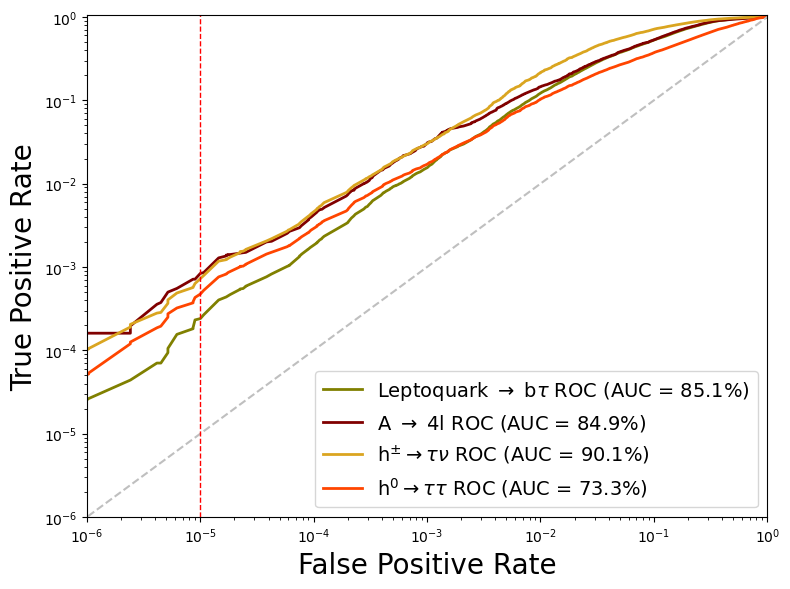

In [64]:
plt.figure(figsize=(8, 6))

#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classification')
plt.plot(fpr_loss_lq, tpr_loss_lq, lw=2, color='olive', label='Leptoquark $\\rightarrow$ b$\\tau$ ROC (AUC = %.1f%%)' % (auc_loss_lq * 100))
plt.plot(fpr_loss_ato4l, tpr_loss_ato4l,  lw=2, color='maroon', label='A $\\rightarrow$ 4l ROC (AUC = %.1f%%)' % (auc_loss_ato4l * 100))
plt.plot(fpr_loss_hChToTauNu, tpr_loss_hChToTauNu, color='goldenrod', lw=2, label='h$^{\\pm} \\rightarrow \\tau  \\nu $ ROC (AUC = %.1f%%)' % (auc_loss_hChToTauNu * 100))
plt.plot(fpr_loss_hToTauTau, tpr_loss_hToTauTau,  lw=2, color='orangered',  label='h$^0 \\rightarrow \\tau \\tau$ ROC (AUC = %.1f%%)' % (auc_loss_hToTauTau * 100))
plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')

plt.semilogx()
plt.semilogy()
plt.xlim([10**-(6), 1.0])
plt.ylim([10**-(6), 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
#plt.title('Receiver Operating Characteristics (ROC) Curves for different BSM signals')
plt.legend(loc='lower right',fontsize=14)
plt.tight_layout()
plt.savefig('roc_pid_log_f.png')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency

plt.show()

In [33]:
lilq = []
for anomalousy in top_indices_l:
    lilq.append(np.argmin(anom_scores_l[anomalousy]))

lill = []
for anomalousy in top_indices_ato4l:
    lill.append(np.argmin(anom_scores_ato4l[anomalousy]))

lilb = []
for anomalousy in top_indices:
    lilb.append(np.argmin(anom_scores[anomalousy]))

liltt = []
for anomalousy in top_indices_hToTauTau:
    liltt.append(np.argmin(anom_scores_hToTauTau[anomalousy]))

liltn = []
for anomalousy in top_indices_hChToTauNu:
    liltn.append(np.argmin(anom_scores_hChToTauNu[anomalousy]))

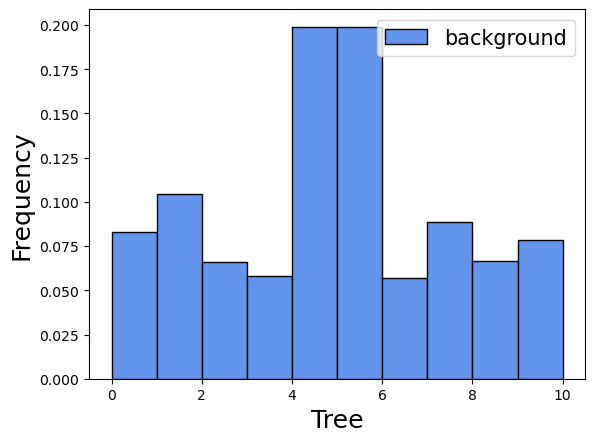

In [34]:

plt.hist(lilb,  edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="background", color='cornflowerblue')

plt.xlabel('Tree',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.legend(fontsize=15)
plt.savefig('besttreebkg.png')  # Save the figure with the desired name and format

plt.show()

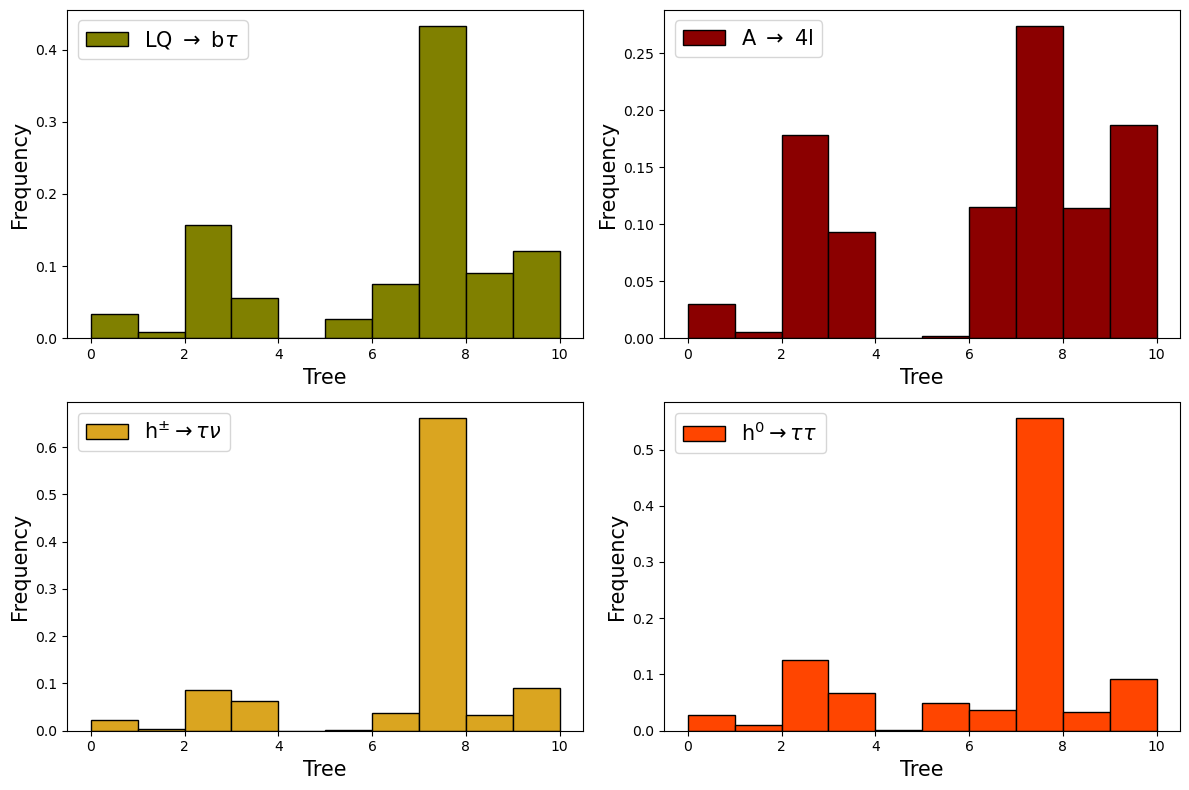

In [35]:
#thanks chat gbt
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#fig.suptitle('Tree distr', fontsize=16)
fonti= 15
fontill = 15
# Plot 1
axs[0, 0].hist(lilq,  edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="LQ $\\rightarrow$ b$\\tau$", color = 'olive')
#axs[0, 0].set_title('Leptoquark $\\rightarrow$ b$\\tau$')
axs[0, 0].set_ylabel('Frequency',fontsize=fonti)
axs[0, 0].set_xlabel('Tree',fontsize=fonti)
axs[0, 0].legend(fontsize=fontill)

# Plot 2
axs[0, 1].hist(lill, edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="A $\\rightarrow$ 4l", color = 'darkred')
#axs[0, 1].set_title('A $\\rightarrow$ 4l')
axs[0, 1].set_ylabel('Frequency',fontsize=fonti)
axs[0, 1].set_xlabel('Tree',fontsize=fonti)
axs[0, 1].legend(fontsize=fontill)

# Plot 3
axs[1, 0].hist(liltn, edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="h$^{\\pm} \\rightarrow \\tau  \\nu$", color = 'goldenrod')
#axs[1, 0].set_title('h$^{\\pm} \\rightarrow \\tau  \\nu$')
axs[1, 0].set_ylabel('Frequency',fontsize=fonti)
axs[1, 0].set_xlabel('Tree',fontsize=fonti)
axs[1, 0].legend(fontsize=fontill)

# Plot 4
axs[1, 1].hist(liltt, edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="h$^0 \\rightarrow \\tau \\tau$", color='orangered')
#axs[1, 1].set_title('h$^0 \\rightarrow \\tau \\tau$')
axs[1, 1].set_ylabel('Frequency',fontsize=fonti)
axs[1, 1].set_xlabel('Tree',fontsize=fonti)
axs[1, 1].legend(fontsize=fontill)
plt.tight_layout()

plt.savefig('besttreemaybe.png')  # Save the figure with the desired name and format

plt.show()

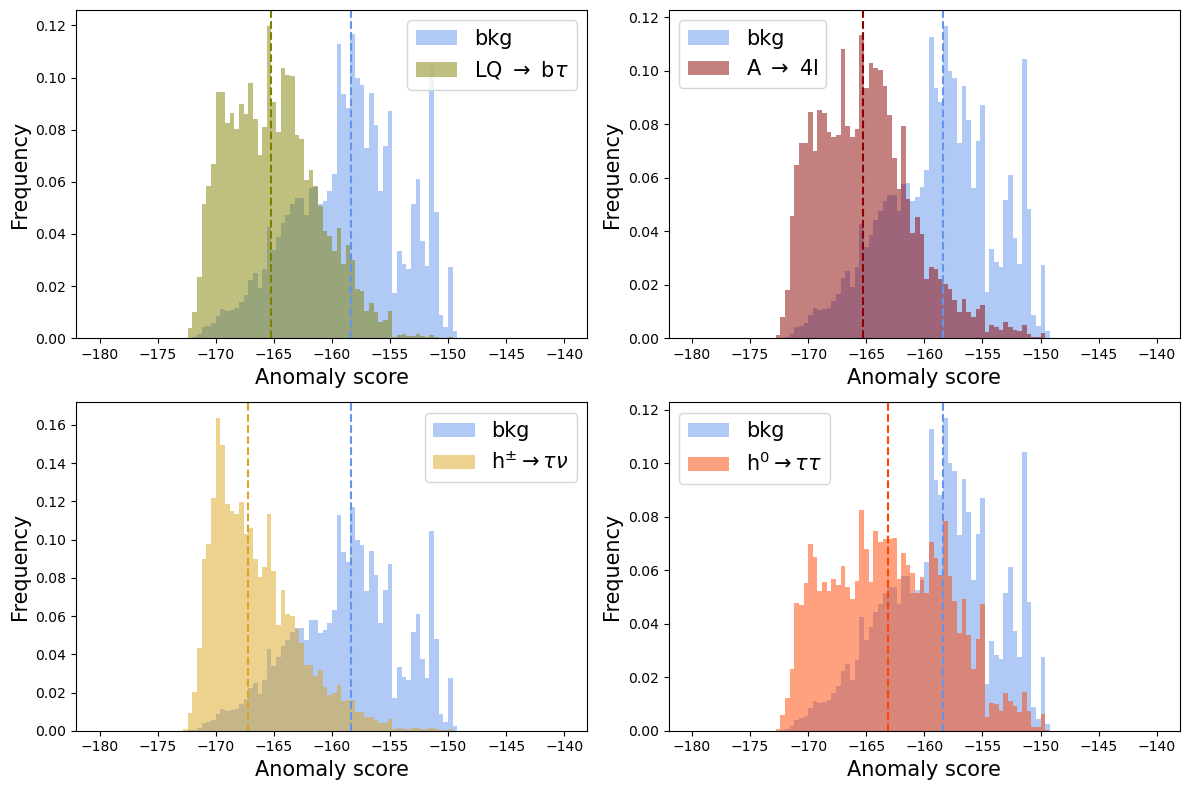

In [36]:
#thanks chat gbt
binsize = 100
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
#fig.suptitle('50th percentile anomaly score distribution for different BSM signals', fontsize=16)


# Plot 1
axs[0, 0].hist(min_score,bins=binsize, density=True, range=(-180, -140), label="bkg", alpha=0.5, color='cornflowerblue')
axs[0, 0].hist(min_score_l, bins=binsize, density=True, range=(-180, -140), label="LQ $\\rightarrow$ b$\\tau$", alpha=0.5, color = 'olive')
#axs[0, 0].set_title('Leptoquark $\\rightarrow$ b$\\tau$')
axs[0, 0].set_ylabel('Frequency',fontsize=fonti)
axs[0, 0].set_xlabel('Anomaly score',fontsize=fonti)
axs[0, 0].legend(fontsize=fonti)

# Plot 2
axs[0, 1].hist(min_score,bins=binsize, density=True, range=(-180, -140), label="bkg", alpha=0.5, color='cornflowerblue' )
axs[0, 1].hist(min_score_ato4l, bins=binsize, density=True, range=(-180, -140), label="A $\\rightarrow$ 4l", alpha=0.5, color = 'darkred')
#axs[0, 1].set_title('A $\\rightarrow$ 4l')
axs[0, 1].set_ylabel('Frequency',fontsize=fonti)
axs[0, 1].set_xlabel('Anomaly score',fontsize=fonti)
axs[0, 1].legend(fontsize=fontill)

# Plot 3
axs[1, 0].hist(min_score,bins=binsize, density=True, range=(-180, -140), label="bkg", alpha=0.5, color='cornflowerblue')
axs[1, 0].hist(min_score_hChToTauNu, bins=binsize, density=True, range=(-180, -140), label="h$^{\\pm} \\rightarrow \\tau  \\nu$", alpha=0.5, color = 'goldenrod')
#axs[1, 0].set_title('h$^{\\pm} \\rightarrow \\tau  \\nu$')
axs[1, 0].set_ylabel('Frequency',fontsize=fonti)
axs[1, 0].set_xlabel('Anomaly score',fontsize=fonti)
axs[1, 0].legend(fontsize=fontill)

# Plot 4
axs[1, 1].hist(min_score,bins=binsize, density=True, range=(-180, -140), label="bkg", alpha=0.5, color='cornflowerblue')
axs[1, 1].hist(min_score_hToTauTau, bins=binsize, density=True, range=(-180, -140), label="h$^0 \\rightarrow \\tau \\tau$", alpha=0.5, color='orangered')
#axs[1, 1].set_title('h$^0 \\rightarrow \\tau \\tau$')
axs[1, 1].set_ylabel('Frequency',fontsize=fonti)
axs[1, 1].set_xlabel('Anomaly score',fontsize=fonti)
axs[1, 1].legend(fontsize=fontill)
plt.tight_layout()


# Plot 1
axs[0, 0].axvline(x=np.median(min_score), label = "median", color='cornflowerblue', linestyle='--')
axs[0, 1].axvline(x=np.median(min_score), color='cornflowerblue', linestyle='--')
axs[1, 0].axvline(x=np.median(min_score), color='cornflowerblue', linestyle='--')
axs[1, 1].axvline(x=np.median(min_score), color='cornflowerblue', linestyle='--')
axs[0, 0].axvline(x=np.median(min_score_l), color='olive', linestyle='--')
axs[0, 1].axvline(x=np.median(min_score_ato4l), color='darkred', linestyle='--')
axs[1, 0].axvline(x=np.median(min_score_hChToTauNu), color='goldenrod', linestyle='--')
axs[1, 1].axvline(x=np.median(min_score_hToTauTau), color='orangered', linestyle='--')


plt.savefig('anomnomnom.png')  # Save the figure with the desired name and format

plt.show()

In [37]:
top_indices_l, anom_pts_l, anom_scores_l, anom_pct_l, min_score_l = forest.predict(np.transpose(ltq), err=0.1)
anomnomnom_bkg = [np.transpose(x_test)[:,i] for i in top_indices]
anomnomnom_l = [np.transpose(ltq)[:,i] for i in top_indices_l]
anomnomnom_ato4l = [np.transpose(ato4l)[:,i] for i in top_indices_ato4l]
anomnomnom_hToTauTau = [np.transpose(hToTauTau)[:,i] for i in top_indices_hToTauTau]
anomnomnom_hChToTauNu = [np.transpose(hChToTauNu)[:,i] for i in top_indices_hChToTauNu]

In [50]:
pred_ltq = forest.predict_print(np.transpose(anomnomnom_l)[:,0:10], trees = [7])
pred_ltq = forest.predict_print(np.transpose(anomnomnom_ato4l)[:,0:10], trees = [7])
pred_ltq = forest.predict_print(np.transpose(anomnomnom_hToTauTau)[:,0:10], trees = [7])
pred_ltq = forest.predict_print(np.transpose(anomnomnom_hChToTauNu)[:,0:10], trees = [7])



tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
no more child and the score given is -174.62889502486343


tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
no more child and the score given is -174.62889502486343


tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
no more child and the score given is -174.62889502486343


tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
no more child and the score given is -174.62889502486343


In [48]:
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_l)[:,0:10], trees = [0,1,2,3,4,5,6,7,8,9])



tree nr. 0
n_child 3
self.split_axis 3
self.split_vals : [-0.364414781332016, 0.08596383221447468]
index_split :  [[5, 6, 7, 8], [1, 2, 3, 4, 9], [0]]
n_child 2
self.split_axis 10
self.split_vals : [-0.4913293719291687]
index_split :  [[], [5, 6, 7, 8]]
n_child 2
self.split_axis 15
self.split_vals : [0.40865737199783325]
index_split :  [[], [5, 6, 7, 8]]
no more child and the score given is -173.0069152381145
n_child 3
self.split_axis 28
self.split_vals : [-0.12804684042930603, 0.6315153241157532]
index_split :  [[], [], [1, 2, 3, 4, 9]]
n_child 3
self.split_axis 37
self.split_vals : [-1.17291259765625, 1.0537028312683105]
index_split :  [[4], [1, 2, 3], [9]]
no more child and the score given is -170.10863822728265
n_child 3
self.split_axis 31
self.split_vals : [-0.33773356676101685, 0.14593829214572906]
index_split :  [[2, 3], [], [1]]
no more child and the score given is -166.52345735661083
no more child and the score given is -167.48956463779703
no more child and the score given i

In [45]:
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_ato4l)[:,0:10], trees = [0,1,2,3,4,5,6,7,8,9])



tree nr. 0
n_child 3
self.split_axis 3
self.split_vals : [-0.364414781332016, 0.08596383221447468]
index_split :  [[3, 4, 5, 6, 7, 9], [2], [0, 1, 8]]
n_child 2
self.split_axis 10
self.split_vals : [-0.4913293719291687]
index_split :  [[], [3, 4, 5, 6, 7, 9]]
n_child 2
self.split_axis 15
self.split_vals : [0.40865737199783325]
index_split :  [[3, 4, 5, 6, 7, 9], []]
n_child 2
self.split_axis 37
self.split_vals : [0.5490078330039978]
index_split :  [[3, 4, 5, 6, 7, 9], []]
n_child 3
self.split_axis 0
self.split_vals : [54.686716079711914, 71.92937660217285]
index_split :  [[3, 4, 5, 6, 7, 9], [], []]
n_child 3
self.split_axis 30
self.split_vals : [-0.9733076393604279, 0.46439406275749207]
index_split :  [[7], [3, 6], [4, 5, 9]]
no more child and the score given is -163.77379745153212
n_child 2
self.split_axis 30
self.split_vals : [-0.34368541836738586]
index_split :  [[6], [3]]
no more child and the score given is -163.3386672913668
n_child 3
self.split_axis 1
self.split_vals : [-1.43

In [46]:
pred_hToTauTau = forest.predict_print(np.transpose(anomnomnom_hToTauTau)[:,0:10], trees = [0,1,2,3,4,5,6,7,8,9])



tree nr. 0
n_child 3
self.split_axis 3
self.split_vals : [-0.364414781332016, 0.08596383221447468]
index_split :  [[0, 1, 2, 3, 4, 6, 7], [5, 9], [8]]
n_child 2
self.split_axis 10
self.split_vals : [-0.4913293719291687]
index_split :  [[], [0, 1, 2, 3, 4, 6, 7]]
n_child 2
self.split_axis 15
self.split_vals : [0.40865737199783325]
index_split :  [[], [0, 1, 2, 3, 4, 6, 7]]
no more child and the score given is -173.0069152381145
n_child 3
self.split_axis 28
self.split_vals : [-0.12804684042930603, 0.6315153241157532]
index_split :  [[], [], [5, 9]]
n_child 3
self.split_axis 37
self.split_vals : [-1.17291259765625, 1.0537028312683105]
index_split :  [[], [5, 9], []]
n_child 3
self.split_axis 31
self.split_vals : [-0.33773356676101685, 0.14593829214572906]
index_split :  [[5, 9], [], []]
no more child and the score given is -166.52345735661083
n_child 2
self.split_axis 40
self.split_vals : [-1.5638483762741089]
index_split :  [[8], []]
no more child and the score given is -173.5883206675

In [49]:
pred_hChToTauNu = forest.predict_print(np.transpose(anomnomnom_hChToTauNu)[:,0:10], trees = [0,1,2,3,4,5,6,7,8,9])



tree nr. 0
n_child 3
self.split_axis 3
self.split_vals : [-0.364414781332016, 0.08596383221447468]
index_split :  [[1, 5, 7, 9], [8], [0, 2, 3, 4, 6]]
n_child 2
self.split_axis 10
self.split_vals : [-0.4913293719291687]
index_split :  [[], [1, 5, 7, 9]]
n_child 2
self.split_axis 15
self.split_vals : [0.40865737199783325]
index_split :  [[], [1, 5, 7, 9]]
no more child and the score given is -173.0069152381145
n_child 3
self.split_axis 28
self.split_vals : [-0.12804684042930603, 0.6315153241157532]
index_split :  [[], [], [8]]
n_child 3
self.split_axis 37
self.split_vals : [-1.17291259765625, 1.0537028312683105]
index_split :  [[], [8], []]
n_child 3
self.split_axis 31
self.split_vals : [-0.33773356676101685, 0.14593829214572906]
index_split :  [[8], [], []]
no more child and the score given is -166.52345735661083
n_child 2
self.split_axis 40
self.split_vals : [-1.5638483762741089]
index_split :  [[0, 2, 3, 4, 6], []]
no more child and the score given is -173.58832066752578


tree nr.

In [68]:
forest.predict_print(np.transpose(ato4l)[:,0:100], trees = [0,1,2,3,4,5,6,7,8,9])




tree nr. 0
n_child 3
self.split_axis 3
self.split_vals : [-0.364414781332016, 0.08596383221447468]
index_split :  [[1, 14, 19, 27, 30, 31, 50, 53, 59, 64, 65, 66, 71, 73, 74, 85, 87, 89, 96], [2, 7, 8, 9, 12, 13, 15, 17, 18, 22, 25, 28, 29, 33, 34, 35, 36, 38, 39, 43, 44, 45, 46, 48, 54, 55, 56, 57, 58, 60, 61, 63, 69, 72, 75, 77, 78, 81, 83, 84, 86, 90, 91, 92, 97, 98, 99], [0, 3, 4, 5, 6, 10, 11, 16, 20, 21, 23, 24, 26, 32, 37, 40, 41, 42, 47, 49, 51, 52, 62, 67, 68, 70, 76, 79, 80, 82, 88, 93, 94, 95]]
n_child 2
self.split_axis 10
self.split_vals : [-0.4913293719291687]
index_split :  [[74], [1, 14, 19, 27, 30, 31, 50, 53, 59, 64, 65, 66, 71, 73, 85, 87, 89, 96]]
no more child and the score given is 0
n_child 2
self.split_axis 15
self.split_vals : [0.40865737199783325]
index_split :  [[1, 14, 19, 27, 30, 31, 50, 53, 59, 64, 65, 66, 71, 73, 85, 87, 89, 96], []]
n_child 2
self.split_axis 37
self.split_vals : [0.5490078330039978]
index_split :  [[1, 14, 19, 31, 50, 53, 59, 64, 65, 66

In [55]:
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_l)[:,0:100], trees = [7])
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_ato4l)[:,0:100], trees = [7])
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_hChToTauNu)[:,0:100], trees = [7])
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_hToTauTau)[:,0:100], trees = [7])



tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]
no more child and the score given is -174.62889502486343


tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[78], [13, 23, 24, 33, 49, 68, 74, 75, 82, 83, 84, 85, 86, 89, 92, 93, 98], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66

In [62]:
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_bkg)[:,0:10], trees = [7])




tree nr. 7
n_child 3
self.split_axis 35
self.split_vals : [8.514570236206055, 33.92120170593262]
index_split :  [[], [], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
no more child and the score given is -174.62889502486343


In [56]:
np.transpose(anomnomnom_l)[35,0:10]

array([ 72.90570068,  53.03910065,  45.16992569,  84.90492249,
        39.07478714, 106.35575867,  61.98046112, 109.55208588,
        36.11126328,  41.75558853])

In [57]:
np.transpose(anomnomnom_ato4l)[35,0:10]

array([47.10943604, 61.45763016, 60.89473343, 75.69145966, 44.1651001 ,
       38.24698639, 64.29045868, 64.99151611, 37.52720261, 57.21037292])

In [58]:
np.transpose(anomnomnom_hChToTauNu)[35,0:10]

array([ 34.36219025,  39.25198364,  50.92721176,  34.26588821,
        37.89386368, 127.31520081,  58.47251511,  62.59825134,
        49.34736633,  57.6886673 ])

In [61]:
np.transpose(anomnomnom_hToTauTau)[35,0:10]

array([43.15279388, 45.72290421, 82.72148895, 45.18172836, 53.0704155 ,
       36.08455658, 48.85973358, 81.94275665, 48.12976456, 45.23946381])

In [ ]:
anomnomnom_ato4l = [np.transpose(new_set_ltq)[:,i] for i in tindices_ato4l]
anomnomnom_hToTauTau = [np.transpose(new_set_hChToTauNu)[:,i] for i in tindices_hToTauTau]
anomnomnom_hChToTauNu = [np.transpose(new_set_hToTauTau)[:,i] for i in tindices_hChToTauNu]

In [70]:
top_indices_ato4l_all, anom_data_ato4l_all, anom_scores_ato4l_all, pst_ato4l_all, min_score_ato4l_all = forest.predict(np.transpose(ato4l), err=1)

(array([0.08656578, 0.07838268, 0.06530401, 0.03714556, 0.10278904,
        0.06907395, 0.2110454 , 0.04293448, 0.22771534, 0.07904376]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

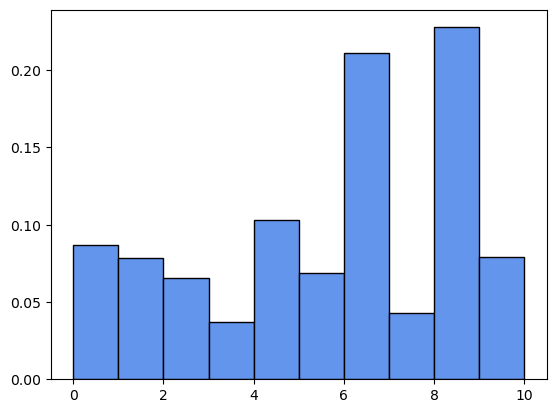

In [71]:
lill_all = []
for anomalousy in top_indices_ato4l_all:
    lill_all.append(np.argmin(anom_scores_ato4l_all[anomalousy]))
plt.hist(lill_all,  edgecolor= "black", density=True, bins=[0,1,2,3,4,5,6,7,8,9,10], label="background", color='cornflowerblue')

In [77]:
pred_ato4l = forest.predict_print(np.transpose(anomnomnom_bkg)[:,0:1000], trees = [8])




tree nr. 8
n_child 3
self.split_axis 19
self.split_vals : [-0.009568263776600361, 0.4694170653820038]
index_split :  [[0, 3, 4, 5, 6, 13, 14, 18, 19, 20, 21, 22, 23, 24, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 129, 130, 132, 134, 135, 138, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 167, 168, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 232, 234, 235, 238, 240, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 263, 264, 265, 266, 267, 268, 269, 271, 272, 273, 275, 278, 279, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 295, 297, 298, 300, 301, 302, 303, 305, 307, 308, 309, 310, 312, 356, 358, 361, 364, 366, 367, 369, 370, 371, 374, 376, 378, 379, 381, 383, 386, 389, 390

In [ ]:
splits_of_dict = forest.split_dict

oww = []
noww = []
for jj in range(forest.dim):
    ll = []
    for i in range(forest.n_trees):
        ll += [item for sublist in splits_of_dict[i][jj] for item in sublist]
    #print(f"this is the histogram of splits of dimension {jj} and its length {len(ll)}")
    oww.append(jj)
    noww.append(len(ll))

In [ ]:
plt.plot(oww, noww, '*', color= "black")
plt.vlines(oww, 0, noww, color= "black")
plt.axvspan(-2, 1.5, alpha=0.5, color='#e0bf73', label = "MET")
plt.axvspan(1.6, 13.5, alpha=0.5, color='#527792', label = "e/gamma") 
plt.axvspan(13.6, 25.5, alpha=0.5, color='#7ca992', label = "muon")  
plt.axvspan(25.6, 58, alpha=0.5, color='#f4f3de', label = "jet") 
plt.xlim(-2,57)
plt.hlines(0, 0-4, 56+4, color = "red", label= "y=0")
#plt.grid()
plt.legend(fontsize=14)
plt.xlabel("feature number",fontsize=14)
plt.ylabel("frequency",fontsize=14)
plt.savefig('frequencyfeature.png')
plt.show()


In [ ]:
egamma_counter_bkg = np.zeros(4)

for egamma in range(4):
    for i in datasets['x_train'][:,1+egamma,0,0]:
        if i > 0:
            egamma_counter_bkg[egamma] += 1

muon_counter_bkg = np.zeros(4)

for muon in range(4):
    for i in datasets['x_train'][:,5+muon,0,0]:
        if i > 0:
            muon_counter_bkg[muon] += 1
            
jet_counter_bkg = np.zeros(10)
for jets in range(10):
    for i in datasets['x_train'][:,9+jets,0,0]:
        if i > 0:
            jet_counter_bkg[jets] += 1

In [ ]:
egamma_counter_lq = np.zeros(4)

for egamma in range(4):
    for i in bsm_datasets['leptoquark'][:,1+egamma,0,0]:
        if i > 0:
            egamma_counter_lq[egamma] += 1

muon_counter_lq = np.zeros(4)

for muon in range(4):
    for i in bsm_datasets['leptoquark'][:,5+muon,0,0]:
        if i > 0:
            muon_counter_lq[muon] += 1
            
jet_counter_lq = np.zeros(10)
for jets in range(10):
    for i in bsm_datasets['leptoquark'][:,9+jets,0,0]:
        if i > 0:
            jet_counter_lq[jets] += 1

In [ ]:
egamma_counter_ato4l = np.zeros(4)

for egamma in range(4):
    for i in bsm_datasets['ato4l'][:,1+egamma,0,0]:
        if i > 0:
            egamma_counter_ato4l[egamma] += 1

muon_counter_ato4l = np.zeros(4)

for muon in range(4):
    for i in bsm_datasets['ato4l'][:,5+muon,0,0]:
        if i > 0:
            muon_counter_ato4l[muon] += 1
            
jet_counter_ato4l = np.zeros(10)
for jets in range(10):
    for i in bsm_datasets['ato4l'][:,9+jets,0,0]:
        if i > 0:
            jet_counter_ato4l[jets] += 1

In [ ]:
egamma_counter_hChToTauNu = np.zeros(4)

for egamma in range(4):
    for i in bsm_datasets['hChToTauNu'][:,1+egamma,0,0]:
        if i > 0:
            egamma_counter_hChToTauNu[egamma] += 1

muon_counter_hChToTauNu = np.zeros(4)

for muon in range(4):
    for i in bsm_datasets['hChToTauNu'][:,5+muon,0,0]:
        if i > 0:
            muon_counter_hChToTauNu[muon] += 1
            
jet_counter_hChToTauNu = np.zeros(10)
for jets in range(10):
    for i in bsm_datasets['hChToTauNu'][:,9+jets,0,0]:
        if i > 0:
            jet_counter_hChToTauNu[jets] += 1

In [ ]:
egamma_counter_hToTauTau = np.zeros(4)

for egamma in range(4):
    for i in bsm_datasets['hToTauTau'][:,1+egamma,0,0]:
        if i > 0:
            egamma_counter_hToTauTau[egamma] += 1

muon_counter_hToTauTau = np.zeros(4)

for muon in range(4):
    for i in bsm_datasets['hToTauTau'][:,5+muon,0,0]:
        if i > 0:
            muon_counter_hToTauTau[muon] += 1
            
jet_counter_hToTauTau = np.zeros(10)
for jets in range(10):
    for i in bsm_datasets['hToTauTau'][:,9+jets,0,0]:
        if i > 0:
            jet_counter_hToTauTau[jets] += 1

In [ ]:
plt.title("egamma distribution")
color = ['cornflowerblue', 'olive', 'darkred', 'goldenrod', 'orangered']
plt.scatter([1,2,3,4], egamma_counter_bkg/len(x_train), label="bkg", color=color[0])
plt.scatter([1,2,3,4], egamma_counter_lq/len(bsm_datasets['leptoquark']), label="lq",color=color[1])
plt.scatter([1,2,3,4], egamma_counter_ato4l/len(bsm_datasets['ato4l']), label="ato4l",color=color[2])
plt.scatter([1,2,3,4], egamma_counter_hChToTauNu/len(bsm_datasets['hChToTauNu']), label="hChToTauNu",color=color[3])
plt.scatter([1,2,3,4], egamma_counter_hToTauTau/len(bsm_datasets['hToTauTau']), label="hToTauTau",color=color[4])
plt.xticks([1,2,3,4], [1,2,3,4])

plt.legend(fontsize=15)

plt.savefig('egamma_counter.png')
plt.show()

In [ ]:
plt.title("muon distribution")

plt.scatter([1,2,3,4], muon_counter_bkg/len(x_train), label="bkg",color=color[0])
plt.scatter([1,2,3,4], muon_counter_lq/len(bsm_datasets['leptoquark']), label="lq",color=color[1])
plt.scatter([1,2,3,4], muon_counter_ato4l/len(bsm_datasets['ato4l']), label="ato4l",color=color[2])
plt.scatter([1,2,3,4], muon_counter_hChToTauNu/len(bsm_datasets['hChToTauNu']), label="hChToTauNu",color=color[3])
plt.scatter([1,2,3,4], muon_counter_hToTauTau/len(bsm_datasets['hToTauTau']), label="hToTauTau",color=color[4])
plt.xticks([1,2,3,4], [1,2,3,4])


plt.legend(fontsize=15)

plt.savefig('muon_counter.png')
plt.show()

In [ ]:
plt.title("jet distribution")
plt.scatter([0,1,2,3,4,5,6,7,8,9], jet_counter_bkg/len(x_train), label="bkg",color=color[0])
plt.scatter([0,1,2,3,4,5,6,7,8,9], jet_counter_lq/len(bsm_datasets['leptoquark']), label="lq",color=color[1])
plt.scatter([0,1,2,3,4,5,6,7,8,9], jet_counter_ato4l/len(bsm_datasets['ato4l']), label="ato4l",color=color[2])
plt.scatter([0,1,2,3,4,5,6,7,8,9], jet_counter_hChToTauNu/len(bsm_datasets['hChToTauNu']), label="hChToTauNu",color=color[3])
plt.scatter([0,1,2,3,4,5,6,7,8,9], jet_counter_hToTauTau/len(bsm_datasets['hToTauTau']), label="hToTauTau",color=color[4])
plt.xticks([0,1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9, 10])


plt.legend(fontsize=15)

plt.savefig('jet_counter.png')
plt.show()

In [ ]:
labels = ['background', 'Leptoquark $\\rightarrow$ b$\\tau$', 'A $\\rightarrow$ 4l', 'h$^{\\pm} \\rightarrow \\tau  \\nu$', 'h$^0 \\rightarrow \\tau \\tau$']
color = ['cornflowerblue', 'olive', 'darkred', 'goldenrod', 'orangered']